In [1]:
import pandas as pd
import gzip
from io import BytesIO
import zipfile
import re
import numpy as np
import swifter
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import multiprocessing

## Loading the data

In [2]:
df_tweets_users = pd.read_csv('data/tweets_of_users.csv').dropna()
df_tweets_parties = pd.read_csv('data/tweets_of_praties.csv').dropna()

df_tweets_users['user_id'] = df_tweets_users['user_id'].astype(int)
df_tweets_parties['user_id'] = df_tweets_parties['user_id'].astype(int)

/Users/yogev/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_tweets_parties.head()

,user_id,party_en,created_at,text
0,1082167187006242817,Kahol_Lavan,Mon Apr 08 17:28:21 +0000 2019,ההודאה של סמוטריץ' על עסקה סודית עם נתניהו לקב...
1,1082167187006242817,Kahol_Lavan,Mon Apr 08 16:31:35 +0000 2019,אנשים מבינים מה הם צריכים לעשות. מבינים שחייבי...
2,1082167187006242817,Kahol_Lavan,Mon Apr 08 16:31:34 +0000 2019,אנחנו חצי מטר מהניצחון. אתמול היינו מטר. חייבי...
3,1082167187006242817,Kahol_Lavan,Mon Apr 08 14:32:22 +0000 2019,עוד 2 מנדטים לניצחון.\nכדי שברביעי נקום למציאו...
4,1082167187006242817,Kahol_Lavan,Mon Apr 08 11:25:17 +0000 2019,עוד 2 מנדטים לניצחון.\nכל קול קובע. אסור לבזבז...


In [4]:
df_tweets_users.head()

,user_id,name,screen_name,created_at,text
0,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 12:13:25 +0000 2019,@Irisleal15 @mmm08080556 איריס תודה. מדובר בבו...
1,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 12:02:53 +0000 2019,@Irisleal15 נראה לי שאת מייחסת חשיבות מועטה מד...
2,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 11:56:42 +0000 2019,@Irisleal15 איריס זה מקרה קלאסי של להרוג את הש...
3,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 10:51:46 +0000 2019,סטאלין שרצח מיליונים מבני עמו. דברי הבל וגם הס...
4,221782855,Sefy Hendler,@SefyHendler,Sat Apr 06 06:40:02 +0000 2019,@ShemuelMeir זה מונמארטר. הפוליטקניק הישן הוא ...


## # of accounts per party 

In [5]:
df_tweets_parties[['text', 'party_en','user_id']].groupby('party_en')['user_id'].nunique().sort_values(ascending=False)

party_en
Halikud             33
Haavoda             32
Kahol_Lavan         24
Shas                13
Kulanu              11
Hayemin_Hahadash    10
Zehut                9
Yahdut_Hatora        8
Ichud_Hayemin        8
Merez                7
Geshser              6
Israel_Beytenu       4
Hadash_Tal           3
Name: user_id, dtype: int64

## # of tweets per party

In [6]:
df_tweets_parties[['text', 'party_en']].groupby('party_en').count().sort_values(by=['text'],ascending=False)

,text
party_en,
Halikud,5753
Haavoda,5489
Kahol_Lavan,3384
Shas,2271
Kulanu,2139
Zehut,1517
Hayemin_Hahadash,1430
Merez,1400
Ichud_Hayemin,1355


## # of users 

In [7]:
print(f'Number of users is {df_tweets_users["user_id"].nunique()}')

Number of users is 8148


# Pre-processing

## Cleaning

In [8]:
def remove_links(text):
    return re.sub('http[s]?://\S+', '', str(text))

In [9]:
df_tweets_parties['clean_text'] = df_tweets_parties['text'].apply(remove_links)
df_tweets_users['clean_text'] = df_tweets_users['text'].apply(remove_links)

## Parties tweets augmantion and cancatination

In [10]:
mean_tweets_per_party = int(df_tweets_parties.groupby('party_en').count()['user_id'].mean())
print(f'Mean of tweets per party: {mean_tweets_per_party}')

Mean of tweets per party: 2145


In [11]:
def concat_text_with_mean_length(x):
    np.random.seed(0)
    ixs = np.random.randint(0, len(x.values), mean_tweets_per_party)
    tweet_list = x.values[ixs]
    
    return ''.join(tweet_list)

In [12]:
grouped = df_tweets_parties[['party_en', 'clean_text']].groupby('party_en')
df_concatenated_tweets_parties = grouped.agg({'clean_text': concat_text_with_mean_length})
df_concatenated_tweets_parties['clean_text_length'] = df_concatenated_tweets_parties['clean_text'].str.len()

In [13]:
df_concatenated_tweets_parties

,clean_text,clean_text_length
party_en,,
Geshser,@ishay_aderet @sefiova @tamarishshalom נו באמת...,191653
Haavoda,השימוע לבזן הוא מעט מדי מאוחר מדי. תושבי המפרץ...,204296
Hadash_Tal,"אישור בניית 31 יחידות דיור בגדה הכבושה בס""כ 22...",206889
Halikud,כל בוקר אני מתעורר ומקווה שמישהו יעצור את הטיר...,204135
Hayemin_Hahadash,RT @amit_segal: גוש הימין מטפס ל-63 מנדטים מאז...,197570
Ichud_Hayemin,שישי הקרוב # שבוע 8 # מפגן העוז למען הבנים# \n...,185863
Israel_Beytenu,@Omerdav @tamarzandberg @akivanovick לא אמרתי ...,206215
Kahol_Lavan,@LinoyBarGeffen בשם החופש עאלק. מעניין האם לשי...,189005
Kulanu,RT @GadiTaub1: קראתי היום ערימה של טוויטים שנו...,192618


## User's tweets cancatination

In [14]:
grouped = df_tweets_users[['user_id', 'clean_text']].groupby('user_id')
df_concatenated_tweets_users = grouped.agg({'clean_text': lambda x: ''.join(x.values)})
df_concatenated_tweets_users = df_concatenated_tweets_users.reset_index()
df_concatenated_tweets_users['user_id'] = df_concatenated_tweets_users['user_id'].astype(int)

In [15]:
df_concatenated_tweets_users.head()

,user_id,clean_text
0,5137,@yoosiiiiii @yullzi בשנות התשעים לא היו מודעים...
1,11080,"@Super_Dori אוקי אוקי, זה לא באמת 😁 פייק ניוז@..."
2,13164,@barzik @Gil__Mor @Haaretz זה כי אתה לא קורא ה...
3,14483,"RT @rikycohen4: שלחו לי עכשיו, העבירו הלאה! הת..."
4,17613,@LiSteinitz @DavidNevo3 הרי לשם זה התגייסה בכל...


## Zip utils

In [16]:
def zip_text(text):
    zip_buffer = BytesIO()
    with zipfile.ZipFile(zip_buffer, mode='w') as zf:
        zf.writestr('zip_file',text, zipfile.ZIP_DEFLATED) 
        
    return zip_buffer

def zip_and_wheight(text):
    return zip_text(text).getbuffer().nbytes

def party_text(party_name):
    return df_concatenated_tweets_parties[df_concatenated_tweets_parties.index == party_name]['clean_text'].values[0]

def zip_and_wheight_delta(text, party_name):
    AT_size = zip_text(party_text(party_name) + text).getbuffer().nbytes
    A_size = df_concatenated_tweets_parties[df_concatenated_tweets_parties.index == party_name]['orig_zip_size'].values[0]
        
    return AT_size - A_size


## Calculate concatenated tweets parties zip size

In [17]:
df_concatenated_tweets_parties['orig_zip_size'] = df_concatenated_tweets_parties['clean_text'].apply(zip_and_wheight)
df_concatenated_tweets_parties

,clean_text,clean_text_length,orig_zip_size
party_en,,,
Geshser,@ishay_aderet @sefiova @tamarishshalom נו באמת...,191653,79094
Haavoda,השימוע לבזן הוא מעט מדי מאוחר מדי. תושבי המפרץ...,204296,114271
Hadash_Tal,"אישור בניית 31 יחידות דיור בגדה הכבושה בס""כ 22...",206889,95200
Halikud,כל בוקר אני מתעורר ומקווה שמישהו יעצור את הטיר...,204135,119306
Hayemin_Hahadash,RT @amit_segal: גוש הימין מטפס ל-63 מנדטים מאז...,197570,99056
Ichud_Hayemin,שישי הקרוב # שבוע 8 # מפגן העוז למען הבנים# \n...,185863,96705
Israel_Beytenu,@Omerdav @tamarzandberg @akivanovick לא אמרתי ...,206215,88944
Kahol_Lavan,@LinoyBarGeffen בשם החופש עאלק. מעניין האם לשי...,189005,106952
Kulanu,RT @GadiTaub1: קראתי היום ערימה של טוויטים שנו...,192618,104681


## Calculate user-party delta zip size  

In [18]:
party_delta_column_names = [party for party in df_concatenated_tweets_parties.index]

In [108]:
def mp_worker(party_name):
    return (party_name,
            df_concatenated_tweets_users['clean_text'].swifter.apply(zip_and_wheight_delta, party_name=party_name))

def mp_handler():
    p = multiprocessing.Pool(20)
    return p.map(mp_worker, party_delta_column_names)

res = mp_handler()

Pandas Apply: 100%|██████████| 1/1 [00:00<00:00, 29.91it/s]


In [109]:
for r in res:
    df_concatenated_tweets_users[r[0]] = r[1]

In [20]:
df_concatenated_tweets_users = pd.read_csv('data/df_concatenated_tweets_users.csv')
df_concatenated_tweets_users['prediction'] = df_concatenated_tweets_users[party_delta_column_names].idxmin(axis=1)

In [93]:
precentege_df = df_concatenated_tweets_users.groupby('prediction').count() / df_concatenated_tweets_users.count()[0]
df_concatenated_tweets_parties['precentege'] = precentege_df['user_id'] * 100
df_concatenated_tweets_parties['precentege'] = df_concatenated_tweets_parties['precentege'].fillna(0)
df_concatenated_tweets_parties['party_he'] = [
                                                'גשר',
                                                'העבודה',
                                                'חד"ש תע"ל',
                                                'הליכוד',
                                                'הימין החדש',
                                                'איחוד הימין',
                                                'ישראל ביתנו',
                                                'כחול לבן',
                                                'כולנו',
                                                'מרצ',
                                                'ש"ס',
                                                'יהדות התורה',
                                                'זהות'
                                               ]
df_concatenated_tweets_parties['party_he_re'] = [
                                                'רשג',
                                                'הדובעה',
                                                'ל"עת ש"דח',
                                                'דוכילה',
                                                'שדחה ןימיה',
                                                'ןימיה דוחיא',
                                                'ונתיב לארשי',
                                                'ןבל לוחכ',
                                                'ונלוכ',
                                                'צרמ',
                                                'ס"ש',
                                                'הרותה תודהי',
                                                'תוהז'
                                               ]

In [94]:
df_concatenated_tweets_parties

,clean_text,clean_text_length,orig_zip_size,precentege,party_he,party_he_re
party_en,,,,,,
Geshser,@ishay_aderet @sefiova @tamarishshalom נו באמת...,191653,79094,0.969563,גשר,רשג
Haavoda,השימוע לבזן הוא מעט מדי מאוחר מדי. תושבי המפרץ...,204296,114271,9.486991,העבודה,הדובעה
Hadash_Tal,"אישור בניית 31 יחידות דיור בגדה הכבושה בס""כ 22...",206889,95200,0.785469,"חד""ש תע""ל","ל""עת ש""דח"
Halikud,כל בוקר אני מתעורר ומקווה שמישהו יעצור את הטיר...,204135,119306,18.654885,הליכוד,דוכילה
Hayemin_Hahadash,RT @amit_segal: גוש הימין מטפס ל-63 מנדטים מאז...,197570,99056,4.246441,הימין החדש,שדחה ןימיה
Ichud_Hayemin,שישי הקרוב # שבוע 8 # מפגן העוז למען הבנים# \n...,185863,96705,7.695140,איחוד הימין,ןימיה דוחיא
Israel_Beytenu,@Omerdav @tamarzandberg @akivanovick לא אמרתי ...,206215,88944,3.939617,ישראל ביתנו,ונתיב לארשי
Kahol_Lavan,@LinoyBarGeffen בשם החופש עאלק. מעניין האם לשי...,189005,106952,8.235150,כחול לבן,ןבל לוחכ
Kulanu,RT @GadiTaub1: קראתי היום ערימה של טוויטים שנו...,192618,104681,28.190967,כולנו,ונלוכ


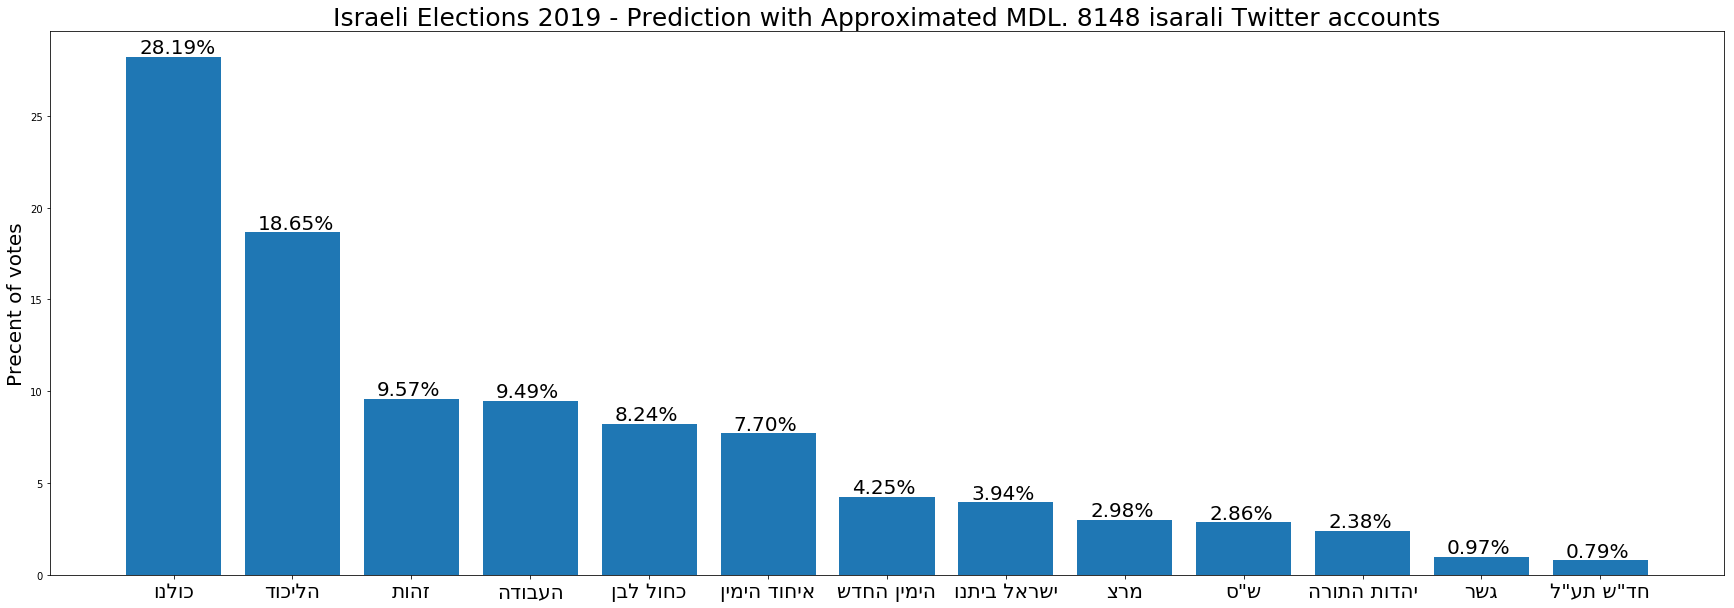

In [97]:
plt.figure(figsize=(30, 10))


data = df_concatenated_tweets_parties.set_index('party_he_re')['precentege'].sort_values(ascending=False)


plt.bar(data.index, data)

for i in range(len(data)):
    plt.text(x = i-0.29 , y = data[i]+0.2, s = f'{data[i]:0.2f}%', size = 20)

plt.ylabel('Precent of votes', fontsize=20)
plt.xticks(fontsize=20)
plt.title('Israeli Elections 2019 - Prediction with Approximated MDL. 8148 isarali Twitter accounts', fontsize=25)
plt.show()